In [2]:
import os
import numpy as np
import pandas as pd
import librosa
from matplotlib import pyplot as plt
import io

import cv2 as cv

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import  GaussianNB
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler


from sklearn.neural_network import MLPClassifier

from warnings import filterwarnings
filterwarnings('ignore')

## Lectura de datos

In [2]:
clases = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [3]:
D = {}

for carpeta in os.listdir('dataset/genres_original/'):
    if carpeta in clases:
        D[carpeta] = []
        for nombreM in os.listdir('dataset/genres_original/' + carpeta):
            try:
                wave, sam_r = librosa.load('dataset/genres_original/'+carpeta+'/'+nombreM)
                D[carpeta].append(wave)
            except:
                print('Erro con el archivo', nombreM, 'Omitiéndolo...' )

## Visualización de datos

In [4]:
cantidades = []
for clase in clases:
    cantidades.append(len(D[clase]))

In [5]:
cantidades

[100, 100, 100, 100, 100, 99, 100, 100, 100, 100]

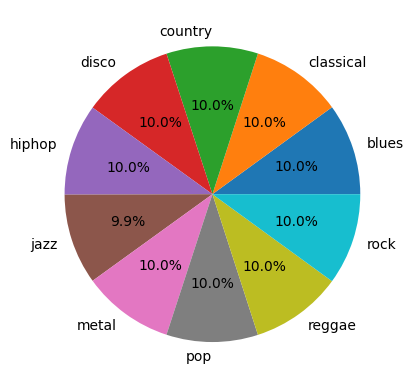

In [6]:
plt.pie(cantidades, labels=clases, autopct='%1.1f%%')
plt.show()

In [7]:
D['classical'][20]

array([-0.05187988, -0.06655884, -0.04104614, ...,  0.08074951,
        0.06646729,  0.04180908], dtype=float32)

In [8]:
librosa.get_duration(y=D['classical'][20])

30.013333333333332

In [9]:
librosa.get_duration(y=D['classical'][0])

30.013333333333332

In [10]:
sam_r

22050

## Obteniendo el espectrograma de Mel

#### ¿Cómo se extrae el espectrograma de Mel?

In [11]:
sample = D['blues'][0]
sample

array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
       -0.06106567, -0.06417847], dtype=float32)

In [12]:
mewSpectogram = librosa.feature.melspectrogram(y=sample, sr=sam_r , hop_length=512)

In [13]:
melSpectrogram_log = librosa.power_to_db(mewSpectogram, ref=np.max)

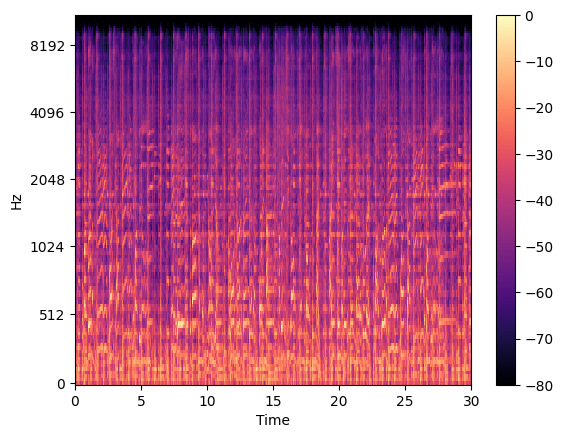

In [24]:
librosa.display.specshow(melSpectrogram_log, x_axis='time', y_axis='mel', sr=sam_r)
plt.colorbar()
plt.show()

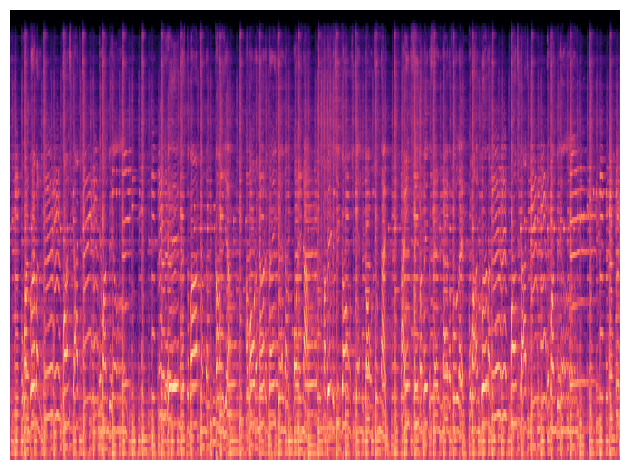

In [14]:
librosa.display.specshow(melSpectrogram_log, x_axis='time', y_axis='mel', sr=sam_r)
plt.axis('off')
plt.tight_layout() #evitar superposición del gráfico
plt.savefig('some.jpg', format='jpg', bbox_inches='tight', pad_inches=0)


In [4]:
def get_mel_spectogram(onda):
    mewSpectogram = librosa.feature.melspectrogram(y=onda, sr=sam_r , hop_length=512)
    melSpectrogram_log = librosa.power_to_db(mewSpectogram, ref=np.max)
    librosa.display.specshow(melSpectrogram_log, x_axis='time', y_axis='mel', sr=sam_r)
    buffer = io.BytesIO()
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(buffer, format='jpg', bbox_inches='tight', pad_inches=0)
    buffer.seek(0)
    img = cv.imdecode(np.frombuffer(buffer.getvalue(), dtype=np.uint8), cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [138]:
def get_mel_spectogram2(onda):
    mewSpectogram = librosa.feature.melspectrogram(y=onda, sr=sam_r , hop_length=512)
    mel_spectrogram_log = librosa.power_to_db(mewSpectogram, ref=np.max)
    mel_spectrogram_log = mel_spectrogram_log.astype(np.uint8)
    spec_img = cv.applyColorMap(mel_spectrogram_log, cv.COLORMAP_JET)
    # spec_img = cv.cvtColor(spec_img, cv.COLOR_BGR2GRAY)
    return spec_img

### Vector de características con MFCC

In [8]:
def get_mfcc(onda, tam_vec = 13):
    mewSpectogram = librosa.feature.melspectrogram(y=onda, sr=sam_r , hop_length=512)
    mel_spectrogram_log = librosa.power_to_db(mewSpectogram, ref=np.max)
    mel_coef = librosa.feature.mfcc(S=mel_spectrogram_log, n_mfcc=tam_vec)
    mel_coef = mel_coef.T
    mel_coef_mean = np.mean(mel_coef, axis = 0)
    return mel_coef_mean

In [143]:
get_mfcc(sample)

array([-500.8226   ,  121.57067  ,  -19.162262 ,   42.363937 ,
         -6.362266 ,   18.621931 ,  -13.699734 ,   15.339802 ,
        -12.274304 ,   10.970945 ,   -8.326061 ,    8.802088 ,
         -3.6699407], dtype=float32)

In [144]:
get_mfcc(sample).shape

(13,)

Pruebas

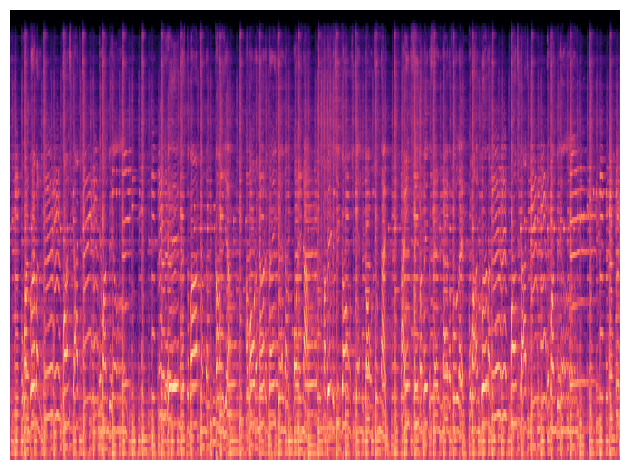

In [17]:
imagen = get_mel_spectogram(sample)

#### Vector de características con SIFT

In [4]:
def miSIFT(I):
    I = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
    sift = cv.xfeatures2d.SIFT_create()
    kp, FVs  = sift.detectAndCompute(I,None)
    return FVs

#### Vector de características con SURF

In [5]:
def miSURF(I):
    I = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
    surf = cv.xfeatures2d.SURF_create(400)
    kp, des = surf.detectAndCompute(I, None)
    return des

#### Extrayendo espectrograma de Mel para todos los audios y extrayendo sus características con SURF y SIFT

#### SURF

In [9]:
D_mel_surf = {}
for clase in clases:
    D_mel_surf[clase] = []
    print('Extrayendo de', clase ,end='')
    for i in range(len(D[clase])):
        audio = D[clase][i]
        img = get_mel_spectogram2(audio)
        try:
            FVs = miSURF(img)
            FV = np.mean(FVs, axis = 0)
            D_mel_surf[clase].append(FV)
            print('.', end='')
        except:
            print('x', end='')
    print('\n¡Finalizado!')

Extrayendo de blues....................................................................................................
¡Finalizado!
Extrayendo de classical....................................................................................................
¡Finalizado!
Extrayendo de country....................................................................................................
¡Finalizado!
Extrayendo de disco....................................................................................................
¡Finalizado!
Extrayendo de hiphop....................................................................................................
¡Finalizado!
Extrayendo de jazz...................................................................................................
¡Finalizado!
Extrayendo de metal...........x................x...................xx....x.............................................
¡Finalizado!
Extrayendo de pop...............................................

In [245]:
for k in D_mel_surf:
    print(len(D_mel_surf[k]))

100
100
100
100
100
99
95
100
100
100


In [249]:
D_mel_surf['classical'][0]

array([-4.0594339e-05, -1.2306641e-04,  7.6534352e-03,  3.4790668e-03,
        6.8335389e-03, -1.8683599e-03,  5.6771774e-02,  2.4726270e-02,
        6.6384864e-03, -5.6376308e-04,  5.5172976e-02,  2.4503622e-02,
        7.5071992e-04, -2.6135511e-05,  7.2012534e-03,  3.3622517e-03,
       -1.6415252e-03, -5.2292628e-04,  5.3755876e-02,  2.4517478e-02,
        4.9505021e-02,  6.2834920e-04,  4.0449905e-01,  1.7179367e-01,
        5.3616069e-02,  1.0248538e-02,  4.0204975e-01,  1.7497812e-01,
        6.3688373e-03,  1.1888026e-03,  5.3628124e-02,  2.4449425e-02,
       -2.8322791e-03,  6.4838528e-06,  5.2169476e-02,  2.4701940e-02,
        5.5945851e-02,  2.6919905e-03,  4.0373090e-01,  1.7462020e-01,
        5.4917395e-02, -7.1162987e-03,  4.0742868e-01,  1.8115149e-01,
        4.9617877e-03, -2.1137280e-04,  5.4427072e-02,  2.4848459e-02,
       -1.1125274e-04, -1.2486784e-05,  7.6218126e-03,  3.5829628e-03,
        6.4431652e-03,  9.7141083e-04,  5.5846348e-02,  2.5020156e-02,
      

In [248]:
D_mel_surf['classical'][0].shape

(64,)

In [10]:
ls_clase = np.concatenate([np.zeros(100), np.ones(100), np.full(100,2), np.full(100,3), np.full(100,4), np.full(99,5), np.full(95,6),np.full(100,7),np.full(100,8),np.full(100,9)], axis=0)

In [251]:
ls_clase.shape

(994,)

In [11]:
ls_audio = np.concatenate([D_mel_surf['blues'], D_mel_surf['classical'], D_mel_surf['country'], D_mel_surf['disco'], D_mel_surf['hiphop'], D_mel_surf['jazz'],D_mel_surf['metal'], D_mel_surf['pop'],D_mel_surf['reggae'],D_mel_surf['rock']], axis=0 )

In [253]:
ls_audio.shape

(994, 64)

In [254]:
ls_base_audio = list(ls_audio)

In [255]:
dicc_df = {'Audio_SURF': ls_base_audio, 'Género':ls_clase }

In [256]:
df_surf_final = pd.DataFrame(dicc_df)

In [257]:
df_surf_final

,Audio_SURF,Género
0,"[-4.3235184e-05, -0.0006257395, 0.0057455823, ...",0.0
1,"[2.5588957e-05, -0.00067769294, 0.0057678972, ...",0.0
2,"[0.00037369478, -0.0006270444, 0.006052617, 0....",0.0
3,"[7.832056e-05, -0.0012656456, 0.0055461335, 0....",0.0
4,"[-1.7852799e-05, -0.0009754602, 0.00618538, 0....",0.0
...,...,...
989,"[0.00022897485, -0.0006775309, 0.0056471666, 0...",9.0
990,"[-0.00047851287, -0.0015597388, 0.0053219665, ...",9.0
991,"[0.0014297185, -0.0025596921, 0.004991307, 0.0...",9.0
992,"[0.0006748747, -0.0005701219, 0.0063578207, 0....",9.0


#### SIFT

In [12]:
D_mel_sift = {}
for clase in clases:
    D_mel_sift[clase] = []
    print('Extrayendo de', clase ,end='')
    for i in range(len(D[clase])):
        audio = D[clase][i]
        img = get_mel_spectogram2(audio)
        try:
            FVs = miSIFT(img)
            FV = np.mean(FVs, axis = 0)
            D_mel_sift[clase].append(FV)
            print('.', end='')
        except:
            print('x', end='')
    print('\n¡Finalizado!')

Extrayendo de blues.

...................................................................................................
¡Finalizado!
Extrayendo de classical....................................................................................................
¡Finalizado!
Extrayendo de country....................................................................................................
¡Finalizado!
Extrayendo de disco....................................................................................................
¡Finalizado!
Extrayendo de hiphop....................................................................................................
¡Finalizado!
Extrayendo de jazz...................................................................................................
¡Finalizado!
Extrayendo de metal....................................................................................................
¡Finalizado!
Extrayendo de pop...................................................................

In [259]:
for k in D_mel_sift:
    print(len(D_mel_sift[k]))

100
100
100
100
100
99
100
100
100
100


In [260]:
D_mel_sift['classical'][0].shape

(128,)

In [13]:
ls_clase_sift = np.concatenate([np.zeros(100), np.ones(100), np.full(100,2), np.full(100,3), np.full(100,4), np.full(99,5), np.full(100,6),np.full(100,7),np.full(100,8),np.full(100,9)], axis=0)

In [14]:
ls_audio_sift = np.concatenate([D_mel_sift['blues'], D_mel_sift['classical'], D_mel_sift['country'], D_mel_sift['disco'], D_mel_sift['hiphop'], D_mel_sift['jazz'],D_mel_sift['metal'], D_mel_sift['pop'],D_mel_sift['reggae'],D_mel_sift['rock']], axis=0 )

In [263]:
ls_base_audio_sift = list(ls_audio_sift)

In [264]:
dicc_df_sift = {'Audio_SIFT': ls_base_audio_sift, 'Género':ls_clase_sift}

In [265]:
df_sift_final = pd.DataFrame(dicc_df_sift)

In [266]:
df_sift_final

,Audio_SIFT,Género
0,"[27.296276, 25.004446, 23.657587, 25.20956, 27...",0.0
1,"[26.73772, 21.2742, 22.976156, 26.144014, 30.4...",0.0
2,"[27.669613, 23.04641, 21.401657, 24.892265, 24...",0.0
3,"[28.495773, 19.136818, 20.720984, 31.196772, 2...",0.0
4,"[28.1536, 23.16125, 23.181963, 26.897068, 26.3...",0.0
...,...,...
994,"[32.67173, 20.758177, 13.328271, 17.459112, 31...",9.0
995,"[29.625235, 22.3371, 14.725047, 15.8568735, 25...",9.0
996,"[28.933578, 23.265682, 17.94096, 15.892989, 15...",9.0
997,"[36.951054, 21.762869, 15.458228, 19.259916, 3...",9.0


### Extrayendo vectores característicos con MFCC

In [15]:
D_mel_mfcc = {}
for clase in clases:
    D_mel_mfcc[clase] = []
    print('Extrayendo de', clase ,end='')
    for i in range(len(D[clase])):
        audio = D[clase][i]
        try:
            fv = get_mfcc(audio)
            D_mel_mfcc[clase].append(fv)
            print('.', end='')
        except:
            print('x', end='')
    print('\n¡Finalizado!')

Extrayendo de blues...

.................................................................................................
¡Finalizado!
Extrayendo de classical....................................................................................................
¡Finalizado!
Extrayendo de country....................................................................................................
¡Finalizado!
Extrayendo de disco....................................................................................................
¡Finalizado!
Extrayendo de hiphop....................................................................................................
¡Finalizado!
Extrayendo de jazz...................................................................................................
¡Finalizado!
Extrayendo de metal....................................................................................................
¡Finalizado!
Extrayendo de pop.....................................................................

In [152]:
for k in D_mel_mfcc:
    print(len(D_mel_mfcc[k]))

100
100
100
100
100
99
100
100
100
100


In [153]:
D_mel_mfcc['classical'][0].shape

(13,)

In [16]:
ls_clase_mfcc = np.concatenate([np.zeros(100), np.ones(100), np.full(100,2), np.full(100,3), np.full(100,4), np.full(99,5), np.full(100,6),np.full(100,7),np.full(100,8),np.full(100,9)], axis=0)

In [17]:
ls_audio_mfcc = np.concatenate([D_mel_mfcc['blues'], D_mel_mfcc['classical'], D_mel_mfcc['country'], D_mel_mfcc['disco'], D_mel_mfcc['hiphop'], D_mel_mfcc['jazz'],D_mel_mfcc['metal'], D_mel_mfcc['pop'],D_mel_mfcc['reggae'],D_mel_mfcc['rock']], axis=0 )

In [156]:
ls_base_audio_mfcc = list(ls_audio_mfcc)

In [157]:
dicc_df_mfcc = {'Audio_MFCC': ls_base_audio_mfcc, 'Género':ls_clase_mfcc}

In [158]:
df_mfcc_final = pd.DataFrame(dicc_df_mfcc)

In [159]:
df_mfcc_final

,Audio_MFCC,Género
0,"[-500.8226, 121.57067, -19.162262, 42.363937, ...",0.0
1,"[-569.11475, 123.98514, 8.947021, 35.86715, 2....",0.0
2,"[-453.34406, 140.44087, -29.084547, 31.686693,...",0.0
3,"[-601.4504, 150.0861, 5.663404, 26.855278, 1.7...",0.0
4,"[-523.3812, 126.20948, -35.58139, 22.139254, -...",0.0
...,...,...
994,"[-402.26117, 109.90478, -23.091644, 59.014496,...",9.0
995,"[-394.64398, 116.20546, -32.160263, 49.11151, ...",9.0
996,"[-362.40466, 115.18235, -47.985886, 52.820343,...",9.0
997,"[-522.97485, 123.657265, -9.745124, 56.613846,...",9.0


# Modelos a usar

### KNN + SURF

In [267]:
X = ls_audio
y = ls_clase

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [269]:
X_train.shape

(795, 64)

In [270]:
X_test.shape

(199, 64)

In [271]:
# Normalización
escalador = StandardScaler()

escalador.fit(X_train)
X_train_norm = escalador.transform(X_train)
X_test_norm = escalador.transform(X_test)

In [272]:
knn = KNeighborsClassifier()

parametros = {'n_neighbors':range(3,100,2)}

optimizador = GridSearchCV(knn,
                            param_grid=parametros,
                            n_jobs=-1,
                            cv=5,
                            verbose=10)

optimizador.fit(X_train_norm,y_train)


Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(3, 100, 2)}, verbose=10)

In [273]:
optimizador.best_score_

0.4767295597484277

In [274]:
optimizador.best_estimator_

KNeighborsClassifier(n_neighbors=7)

In [275]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.5226130653266332

### SVM + SURF

In [276]:
svm = SVC()

parametros = {'C':[1,10,100,1000,10000],
             'kernel':['rbf','linear'],
             'gamma':[0.1,0.01,0.001]}

optimizador = GridSearchCV(svm,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=10)

In [277]:
optimizador.best_score_

0.5886792452830188

In [278]:
optimizador.best_estimator_

SVC(C=1000, gamma=0.01)

In [279]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.5728643216080402

### LR + SURF

In [280]:
lr = LogisticRegression()

parametros= {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

optimizador = GridSearchCV(lr,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=10)

In [281]:
optimizador.best_score_

0.578616352201258

In [282]:
optimizador.best_estimator_

LogisticRegression(C=0.1, solver='liblinear')

In [283]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.5477386934673367

### Naive Bayes + SURF

In [284]:
nb = GaussianNB()

parametros= {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

optimizador = GridSearchCV(nb,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07]}, verbose=10)

In [285]:
optimizador.best_score_

0.4691823899371069

In [286]:
optimizador.best_estimator_

GaussianNB()

In [287]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.4472361809045226

### KNN + SIFT

In [288]:
X = ls_audio_sift
y = ls_clase_sift

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [290]:
escalador = StandardScaler()

escalador.fit(X_train)
X_train_norm = escalador.transform(X_train)
X_test_norm = escalador.transform(X_test)

In [291]:
knn = KNeighborsClassifier()

parametros = {'n_neighbors':range(3,100,2)}

optimizador = GridSearchCV(knn,
                            param_grid=parametros,
                            n_jobs=-1,
                            cv=5,
                            verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(3, 100, 2)}, verbose=10)

In [292]:
optimizador.best_score_

0.5406996855345911

In [293]:
optimizador.best_estimator_

KNeighborsClassifier(n_neighbors=7)

In [294]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.57

### SVM + SIFT

In [295]:
svm = SVC()

parametros = {'C':[1,10,100,1000,10000],
             'kernel':['rbf','linear'],
             'gamma':[0.1,0.01,0.001]}

optimizador = GridSearchCV(svm,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=10)

In [296]:
optimizador.best_score_

0.6658805031446541

In [297]:
optimizador.best_estimator_

SVC(C=10, gamma=0.01)

In [298]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.65

### LR + SIFT

In [299]:
lr = LogisticRegression()

parametros= {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

optimizador = GridSearchCV(lr,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=10)

In [300]:
optimizador.best_score_

0.6746305031446541

In [301]:
optimizador.best_estimator_

LogisticRegression(penalty='l1', solver='liblinear')

In [302]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.68

### NB + SIFT

In [303]:
nb = GaussianNB()

parametros= {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

optimizador = GridSearchCV(nb,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07]}, verbose=10)

In [304]:
optimizador.best_score_

0.4380974842767295

In [305]:
optimizador.best_estimator_

GaussianNB()

In [306]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.44

### KNN + MFCC

In [160]:
X = ls_audio_mfcc
y = ls_clase_mfcc

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [162]:
escalador = StandardScaler()

escalador.fit(X_train)
X_train_norm = escalador.transform(X_train)
X_test_norm = escalador.transform(X_test)

In [163]:
knn = KNeighborsClassifier()

parametros = {'n_neighbors':range(3,100,2)}

optimizador = GridSearchCV(knn,
                            param_grid=parametros,
                            n_jobs=-1,
                            cv=5,
                            verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(3, 100, 2)}, verbose=10)

In [164]:
optimizador.best_score_

0.5507311320754718

In [165]:
optimizador.best_estimator_

KNeighborsClassifier(n_neighbors=9)

In [166]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.555

### SVM + MFCC

In [167]:
svm = SVC()

parametros = {'C':[1,10,100,1000,10000],
             'kernel':['rbf','linear'],
             'gamma':[0.1,0.01,0.001]}

optimizador = GridSearchCV(svm,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=10)

In [168]:
optimizador.best_score_

0.5707154088050315

In [169]:
optimizador.best_estimator_

SVC(C=10, gamma=0.1)

In [170]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.59

### LR + MFCC

In [172]:
lr = LogisticRegression()

parametros= {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

optimizador = GridSearchCV(lr,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=10)

In [173]:
optimizador.best_score_

0.5118553459119497

In [174]:
optimizador.best_estimator_

LogisticRegression(C=10.0, penalty='l1', solver='saga')

In [175]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.55

### NB + MFCC

In [176]:
nb = GaussianNB()

parametros= {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

optimizador = GridSearchCV(nb,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07]}, verbose=10)

In [177]:
optimizador.best_score_

0.39047955974842774

In [178]:
optimizador.best_estimator_

GaussianNB()

In [179]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.365

PROBANDO CON DISTINTOS VALORES DE TAMAÑOS DE MFCC

In [191]:
# fucnción de extracción de datos (todo en uno)
def mfcc_n_selector(N, modelo = 'knn'):

    D_mel_mfcc = {}
    for clase in clases:
        D_mel_mfcc[clase] = []
        #print('Extrayendo de', clase ,end='')
        for i in range(len(D[clase])):
            audio = D[clase][i]
            try:
                fv = get_mfcc(audio, tam_vec=N)
                D_mel_mfcc[clase].append(fv)
                #print('.', end='')
            except:
                print('x', end='')
        #print('\n¡Finalizado!')

    ls_clase_mfcc = np.concatenate([np.zeros(100), np.ones(100), np.full(100,2), np.full(100,3), np.full(100,4), np.full(99,5), np.full(100,6),np.full(100,7),np.full(100,8),np.full(100,9)], axis=0)

    ls_audio_mfcc = np.concatenate([D_mel_mfcc['blues'], D_mel_mfcc['classical'], D_mel_mfcc['country'], D_mel_mfcc['disco'], D_mel_mfcc['hiphop'], D_mel_mfcc['jazz'],D_mel_mfcc['metal'], D_mel_mfcc['pop'],D_mel_mfcc['reggae'],D_mel_mfcc['rock']], axis=0 )

    X = ls_audio_mfcc
    y = ls_clase_mfcc


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

    escalador = StandardScaler()

    escalador.fit(X_train)
    X_train_norm = escalador.transform(X_train)
    X_test_norm = escalador.transform(X_test)


    if modelo == 'knn':
        knn = KNeighborsClassifier()

        parametros = {'n_neighbors':range(3,100,2)}

        optimizador = GridSearchCV(knn,
                            param_grid=parametros,
                            n_jobs=-1,
                            cv=5,
                            verbose=10)

        optimizador.fit(X_train_norm,y_train)

        respuestas = optimizador.predict(X_test_norm)
        acc = accuracy_score(respuestas, y_test)

    elif modelo == 'svm':
        svm = SVC()

        parametros = {'C':[1,10,100,1000,10000],
                    'kernel':['rbf','linear'],
                    'gamma':[0.1,0.01,0.001]}

        optimizador = GridSearchCV(svm,
                                param_grid=parametros,
                                n_jobs=-1,
                                cv=5,
                                verbose=10)

        optimizador.fit(X_train_norm,y_train)

        respuestas = optimizador.predict(X_test_norm)
        acc = accuracy_score(respuestas, y_test)


    elif modelo == 'lr':
        lr = LogisticRegression()

        parametros= {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }

        optimizador = GridSearchCV(lr,
                                param_grid=parametros,
                                n_jobs=-1,
                                cv=5,
                                verbose=10)

        optimizador.fit(X_train_norm,y_train)

        respuestas = optimizador.predict(X_test_norm)
        acc = accuracy_score(respuestas, y_test)

    elif modelo == 'nb':
        nb = GaussianNB()

        parametros= {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }

        optimizador = GridSearchCV(nb,
                                param_grid=parametros,
                                n_jobs=-1,
                                cv=5,
                                verbose=10)

        optimizador.fit(X_train_norm,y_train)

        respuestas = optimizador.predict(X_test_norm)
        acc = accuracy_score(respuestas, y_test)

    return acc

## Con KNN

In [204]:
# Probando con disintos valores de n_mfcc
ls_acc = []
for i in range(12,41):
    print('Probando con valor de N =', i)
    accur = mfcc_n_selector(i, 'knn')
    ls_acc.append(accur)
    print('Finalizado')


Probando con valor de N = 12
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 13
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 14
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 15
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 16
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 17
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 18
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 19
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 20
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 21
Fitting 5 folds for each of 49 candidates, totalling 

Exception ignored in: <function tqdm.__del__ at 0x0000023DF7685CA8>
Traceback (most recent call last):
  File "c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Finalizado
Probando con valor de N = 37
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 38
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 39
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado
Probando con valor de N = 40
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Finalizado


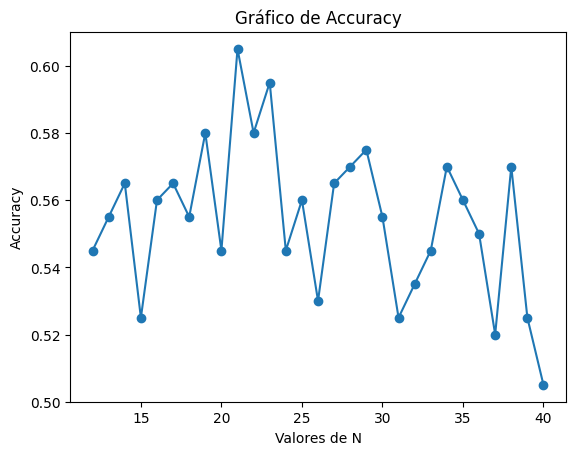

In [207]:
plt.plot(range(12,41), ls_acc, marker='o', linestyle='-')

plt.xlabel('Valores de N')
plt.ylabel('Accuracy')
plt.title('Gráfico de Accuracy')

plt.show()

In [206]:
print('Accuracy:',max(ls_acc), 'N:', range(12,41)[ls_acc.index(max(ls_acc))])

Accuracy: 0.605 N: 21


### Con SVM

In [208]:
ls_acc = []
for i in range(12,41):
    print('Probando con valor de N =', i)
    accur = mfcc_n_selector(i, 'svm')
    ls_acc.append(accur)
    print('Finalizado')

Probando con valor de N = 12
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finalizado
Probando con valor de N = 13
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finalizado
Probando con valor de N = 14
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finalizado
Probando con valor de N = 15
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finalizado
Probando con valor de N = 16
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finalizado
Probando con valor de N = 17
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finalizado
Probando con valor de N = 18
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finalizado
Probando con valor de N = 19
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finalizado
Probando con valor de N = 20
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finalizado
Probando con valor de N = 21
Fitting 5 folds for each of 30 candidates, totalling 

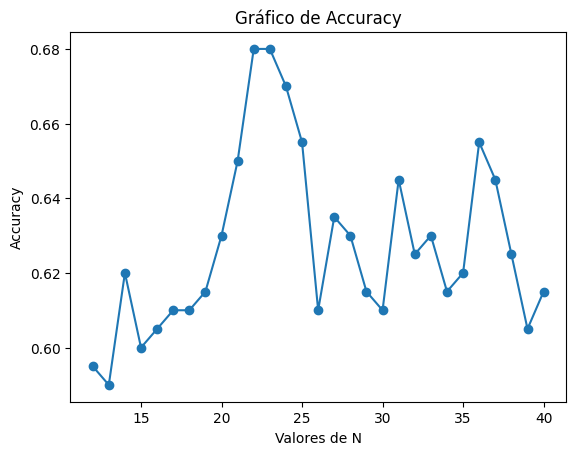

In [209]:
plt.plot(range(12,41), ls_acc, marker='o', linestyle='-')

plt.xlabel('Valores de N')
plt.ylabel('Accuracy')
plt.title('Gráfico de Accuracy')

plt.show()

In [210]:
print('Accuracy:',max(ls_acc), 'N:', range(12,41)[ls_acc.index(max(ls_acc))])

Accuracy: 0.68 N: 22


### Con LR

In [211]:
ls_acc = []
for i in range(12,41):
    print('Probando con valor de N =', i)
    accur = mfcc_n_selector(i, 'lr')
    ls_acc.append(accur)
    print('Finalizado')

Probando con valor de N = 12
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 13
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 14
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 15
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 16
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 17
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 18
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 19
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 21
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 22
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 23
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 24
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 25
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 26
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Finalizado
Probando con valor de N = 27
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Finalizado
Probando con valor de N = 28
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 29
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Finalizado
Probando con valor de N = 30
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Finalizado
Probando con valor de N = 31
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Finalizado
Probando con valor de N = 32
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 33
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 34
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Finalizado
Probando con valor de N = 35
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 36
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 37
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 38
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 39
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Finalizado
Probando con valor de N = 40
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Finalizado


c:\Users\kait_\anaconda3\envs\newEnv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


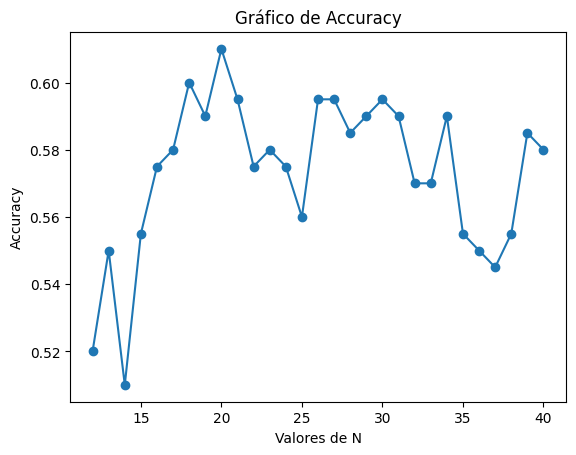

In [212]:
plt.plot(range(12,41), ls_acc, marker='o', linestyle='-')

plt.xlabel('Valores de N')
plt.ylabel('Accuracy')
plt.title('Gráfico de Accuracy')

plt.show()

In [213]:
print('Accuracy:',max(ls_acc), 'N:', range(12,41)[ls_acc.index(max(ls_acc))])

Accuracy: 0.61 N: 20


### Con NB

In [214]:
ls_acc = []
for i in range(12,41):
    print('Probando con valor de N =', i)
    accur = mfcc_n_selector(i, 'nb')
    ls_acc.append(accur)
    print('Finalizado')

Probando con valor de N = 12
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Finalizado
Probando con valor de N = 13
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Finalizado
Probando con valor de N = 14
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Finalizado
Probando con valor de N = 15
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Finalizado
Probando con valor de N = 16
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Finalizado
Probando con valor de N = 17
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Finalizado
Probando con valor de N = 18
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Finalizado
Probando con valor de N = 19
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Finalizado
Probando con valor de N = 20
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Finalizado
Probando con valor de N = 21
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Finalizado


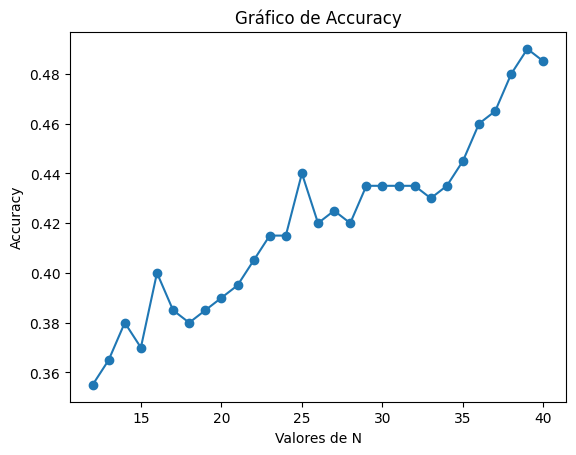

In [215]:
plt.plot(range(12,41), ls_acc, marker='o', linestyle='-')

plt.xlabel('Valores de N')
plt.ylabel('Accuracy')
plt.title('Gráfico de Accuracy')

plt.show()

In [216]:
print('Accuracy:',max(ls_acc), 'N:', range(12,41)[ls_acc.index(max(ls_acc))])

Accuracy: 0.49 N: 39


### Con SURF - fv tamaño 128

In [18]:
def miSURF_128(I):
    I = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
    surf = cv.xfeatures2d.SURF_create(400)
    surf.setExtended(True)
    kp, des = surf.detectAndCompute(I, None)
    return des

In [19]:
D_mel_surf_128 = {}
for clase in clases:
    D_mel_surf_128[clase] = []
    print('Extrayendo de', clase ,end='')
    for i in range(len(D[clase])):
        audio = D[clase][i]
        img = get_mel_spectogram2(audio)
        try:
            FVs = miSURF_128(img)
            FV = np.mean(FVs, axis = 0)
            D_mel_surf_128[clase].append(FV)
            print('.', end='')
        except:
            print('x', end='')
    print('\n¡Finalizado!')

Extrayendo de blues.

...................................................................................................
¡Finalizado!
Extrayendo de classical....................................................................................................
¡Finalizado!
Extrayendo de country....................................................................................................
¡Finalizado!
Extrayendo de disco....................................................................................................
¡Finalizado!
Extrayendo de hiphop....................................................................................................
¡Finalizado!
Extrayendo de jazz...................................................................................................
¡Finalizado!
Extrayendo de metal...........x................x...................xx....x.............................................
¡Finalizado!
Extrayendo de pop...................................................................

In [219]:
for k in D_mel_surf_128:
    print(len(D_mel_surf_128[k]))

100
100
100
100
100
99
95
100
100
100


In [221]:
D_mel_surf_128['classical'][0].shape

(128,)

In [20]:
ls_clase_s128 = np.concatenate([np.zeros(100), np.ones(100), np.full(100,2), np.full(100,3), np.full(100,4), np.full(99,5), np.full(95,6),np.full(100,7),np.full(100,8),np.full(100,9)], axis=0)
ls_audio_s128 = np.concatenate([D_mel_surf_128['blues'], D_mel_surf_128['classical'], D_mel_surf_128['country'], D_mel_surf_128['disco'], D_mel_surf_128['hiphop'], D_mel_surf_128['jazz'],D_mel_surf_128['metal'], D_mel_surf_128['pop'],D_mel_surf_128['reggae'],D_mel_surf_128['rock']], axis=0 )

In [223]:
X = ls_audio_s128
y = ls_clase_s128

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [225]:
# Normalización
escalador = StandardScaler()

escalador.fit(X_train)
X_train_norm = escalador.transform(X_train)
X_test_norm = escalador.transform(X_test)

### KNN + SURF 128

In [226]:
knn = KNeighborsClassifier()

parametros = {'n_neighbors':range(3,100,2)}

optimizador = GridSearchCV(knn,
                            param_grid=parametros,
                            n_jobs=-1,
                            cv=5,
                            verbose=10)

optimizador.fit(X_train_norm,y_train)


Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(3, 100, 2)}, verbose=10)

In [227]:
optimizador.best_score_

0.5006289308176101

In [228]:
optimizador.best_estimator_

KNeighborsClassifier()

In [229]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.5477386934673367

### SVM + SURF 128

In [230]:
svm = SVC()

parametros = {'C':[1,10,100,1000,10000],
             'kernel':['rbf','linear'],
             'gamma':[0.1,0.01,0.001]}

optimizador = GridSearchCV(svm,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=10)

In [231]:
optimizador.best_score_

0.6226415094339621

In [232]:
optimizador.best_estimator_

SVC(C=100, gamma=0.01)

In [233]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.6180904522613065

### LR+ SURF 128

In [234]:
lr = LogisticRegression()

parametros= {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

optimizador = GridSearchCV(lr,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=10)

In [235]:
optimizador.best_score_

0.6062893081761006

In [236]:
optimizador.best_estimator_

LogisticRegression(C=0.1, solver='liblinear')

In [237]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.5728643216080402

### NB + SURF 128

In [238]:
nb = GaussianNB()

parametros= {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

optimizador = GridSearchCV(nb,
                           param_grid=parametros,
                           n_jobs=-1,
                          cv=5,
                          verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07]}, verbose=10)

In [239]:
optimizador.best_score_

0.48553459119496856

In [240]:
optimizador.best_estimator_

GaussianNB()

In [241]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.46733668341708545

# Resultados parciales

In [309]:
dicc_result_par = {'Modelos':['knn + SURF', 'svm + SURF', 'lr + SURF', 'nb + SURF','knn + SURF 128', 'svm + SURF 128', 'lr + SURF 128', 'nb + SURF 128', 'knn + SIFT', 'svm + SIFT', 'lr + SIFT', 'nb + SIFT','knn + MFCC', 'svm + MFCC', 'lr + MFCC', 'nb + MFCC'], 'Accuracy':[0.5226, 0.5728, 0.5477, 0.4472, 0.5477, 0.6180, 0.5728, 0.4673, 0.5700, 0.6500, 0.6800, 0.4400, 0.6050, 0.6800, 0.6100, 0.4900]}

In [310]:
df_resultados_parciales = pd.DataFrame(dicc_result_par)
df_resultados_parciales

,Modelos,Accuracy
0,knn + SURF,0.5226
1,svm + SURF,0.5728
2,lr + SURF,0.5477
3,nb + SURF,0.4472
4,knn + SURF 128,0.5477
5,svm + SURF 128,0.6180
6,lr + SURF 128,0.5728
7,nb + SURF 128,0.4673
8,knn + SIFT,0.5700
9,svm + SIFT,0.6500


### MLP + SURF

In [105]:
X = ls_audio
y = ls_clase

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [107]:
escalador = StandardScaler()

escalador.fit(X_train)
X_train_norm = escalador.transform(X_train)
X_test_norm = escalador.transform(X_test)

In [108]:
mlp = MLPClassifier(random_state=10)

parametros = {'hidden_layer_sizes':[(50,50,50),(50,100,50),(100,100,100),(100,50,100),(50,50,50,50),(100,100,100,100)],
              'activation': ['tanh', 'relu'],
              'learning_rate':['constant', 'adaptative']}

optimizador = GridSearchCV(mlp,
                            param_grid=parametros,
                            n_jobs=-1,
                            cv=5,
                            verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100, 100, 100), (100, 50, 100),
                                                (50, 50, 50, 50),
                                                (100, 100, 100, 100)],
                         'learning_rate': ['constant', 'adaptative']},
             verbose=10)

In [109]:
optimizador.best_score_

0.589937106918239

In [110]:
optimizador.best_estimator_

MLPClassifier(hidden_layer_sizes=(100, 50, 100), random_state=10)

In [111]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.6130653266331658

### MLP + SURF 128

In [112]:
X = ls_audio_s128
y = ls_clase_s128

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [114]:
escalador = StandardScaler()

escalador.fit(X_train)
X_train_norm = escalador.transform(X_train)
X_test_norm = escalador.transform(X_test)

In [115]:
mlp = MLPClassifier(random_state=10)

parametros = {'hidden_layer_sizes':[(50,50,50),(50,100,50),(100,100,100),(100,50,100),(50,50,50,50),(100,100,100,100)],
              'activation': ['tanh', 'relu'],
              'learning_rate':['constant', 'adaptative']}

optimizador = GridSearchCV(mlp,
                            param_grid=parametros,
                            n_jobs=-1,
                            cv=5,
                            verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100, 100, 100), (100, 50, 100),
                                                (50, 50, 50, 50),
                                                (100, 100, 100, 100)],
                         'learning_rate': ['constant', 'adaptative']},
             verbose=10)

In [116]:
optimizador.best_score_

0.5911949685534591

In [117]:
optimizador.best_estimator_

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100, 100),
              random_state=10)

In [118]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.5628140703517588

### MLP + SIFT

In [119]:
X = ls_audio_sift
y = ls_clase_sift

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [121]:
escalador = StandardScaler()

escalador.fit(X_train)
X_train_norm = escalador.transform(X_train)
X_test_norm = escalador.transform(X_test)

In [122]:
mlp = MLPClassifier(random_state=10)

parametros = {'hidden_layer_sizes':[(50,50,50),(50,100,50),(100,100,100),(100,50,100),(50,50,50,50),(100,100,100,100)],
              'activation': ['tanh', 'relu'],
              'learning_rate':['constant', 'adaptative']}

optimizador = GridSearchCV(mlp,
                            param_grid=parametros,
                            n_jobs=-1,
                            cv=5,
                            verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100, 100, 100), (100, 50, 100),
                                                (50, 50, 50, 50),
                                                (100, 100, 100, 100)],
                         'learning_rate': ['constant', 'adaptative']},
             verbose=10)

In [123]:
optimizador.best_score_

0.6571147798742139

In [124]:
optimizador.best_estimator_

MLPClassifier(hidden_layer_sizes=(100, 50, 100), random_state=10)

In [125]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.67

### MLP + MFCC

In [126]:
X = ls_audio_mfcc
y = ls_clase_mfcc

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [128]:
escalador = StandardScaler()

escalador.fit(X_train)
X_train_norm = escalador.transform(X_train)
X_test_norm = escalador.transform(X_test)

In [129]:
mlp = MLPClassifier(random_state=10)

parametros = {'hidden_layer_sizes':[(50,50,50),(50,100,50),(100,100,100),(100,50,100),(50,50,50,50),(100,100,100,100)],
              'activation': ['tanh', 'relu'],
              'learning_rate':['constant', 'adaptative']}

optimizador = GridSearchCV(mlp,
                            param_grid=parametros,
                            n_jobs=-1,
                            cv=5,
                            verbose=10)

optimizador.fit(X_train_norm,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100, 100, 100), (100, 50, 100),
                                                (50, 50, 50, 50),
                                                (100, 100, 100, 100)],
                         'learning_rate': ['constant', 'adaptative']},
             verbose=10)

In [130]:
optimizador.best_score_

0.5857311320754717

In [131]:
optimizador.best_estimator_

MLPClassifier(hidden_layer_sizes=(100, 50, 100), random_state=10)

In [132]:
respuestas = optimizador.predict(X_test_norm)
accuracy_score(respuestas, y_test)

0.59

# Tabla Final sin CNN

In [3]:
dicc_result_fin = {'Modelos':['knn + SURF', 'svm + SURF', 'lr + SURF', 'nb + SURF','knn + SURF 128', 'svm + SURF 128', 'lr + SURF 128', 'nb + SURF 128', 'knn + SIFT', 'svm + SIFT', 'lr + SIFT', 'nb + SIFT','knn + MFCC', 'svm + MFCC', 'lr + MFCC', 'nb + MFCC' , 'MLP + SURF', 'MLP + SURF 128', 'MLP + SIFT', 'MLP + MFCC'], 'Accuracy':[0.5226, 0.5728, 0.5477, 0.4472, 0.5477, 0.6180, 0.5728, 0.4673, 0.5700, 0.6500, 0.6800, 0.4400, 0.6050, 0.6800, 0.6100, 0.4900, 0.6130, 0.5628, 0.6700, 0.5900]}

In [4]:
df_final = pd.DataFrame(dicc_result_fin)

In [5]:
df_final

,Modelos,Accuracy
0,knn + SURF,0.5226
1,svm + SURF,0.5728
2,lr + SURF,0.5477
3,nb + SURF,0.4472
4,knn + SURF 128,0.5477
5,svm + SURF 128,0.6180
6,lr + SURF 128,0.5728
7,nb + SURF 128,0.4673
8,knn + SIFT,0.5700
9,svm + SIFT,0.6500
